In [2]:
import sys
import os
import numpy as np
from statsmodels.tsa.stattools import coint, adfuller
from scipy.stats import boxcox

# Define the path to the parent directory of data_analysis
parent_dir = '/Users/nielsvanwinden/Projects/Projects/Inholland/Scenario_Generator/src'

# Add the parent directory to sys.path
sys.path.append(parent_dir)

from data_analysis import *
from model import *

In [3]:
df = load_macro_economic_data("/Users/nielsvanwinden/Projects/Projects/Inholland/Scenario_Generator/data/dataset.csv")

df = df[df["macro_code"].isin(["gdp_growth", "unemployment_rate"])]

delta = abs(df[df["macro_code"] == "gdp_growth"]["time_series_value"].min())

# Step 1: Initialize with original values
df["transformed_time_series_value"] = df["time_series_value"]

# Step 2: Apply specific transformation
# df.loc[df["macro_code"] == "gdp_growth", "transformed_time_series_value"] = (
#     np.sqrt(df.loc[df["macro_code"] == "gdp_growth", "transformed_time_series_value"] + delta)
# )
df.loc[df["macro_code"] == "unemployment_rate", "transformed_time_series_value"] = (
    (df.loc[df["macro_code"] == "unemployment_rate", "transformed_time_series_value"] - df.loc[df["macro_code"] == "unemployment_rate", "transformed_time_series_value"].shift(1))/df.loc[df["macro_code"] == "unemployment_rate", "transformed_time_series_value"].shift(1)
)


# Step 3: Reshape data into a pivot table
pivot_df = df.pivot(index='pit_date', columns='macro_code', values='transformed_time_series_value')
pivot_df.index = pd.to_datetime(pivot_df.index)  # Ensure datetime index

# # Step 3: Reshape data into a pivot table
# pivot_df = df.pivot(index='pit_date', columns='macro_code', values='time_series_value')
# pivot_df.index = pd.to_datetime(pivot_df.index)  # Ensure datetime index

# Step 4: Interpolate
pivot_df = pivot_df.asfreq('QE').interpolate(method='linear')  # Cubic interpolation
pivot_df = pivot_df.dropna()

print(pivot_df)

Data loaded successfully from /Users/nielsvanwinden/Projects/Projects/Inholland/Scenario_Generator/data/dataset.csv.
macro_code  gdp_growth  unemployment_rate
pit_date                                 
1996-03-31       0.024          -0.048679
1996-06-30       0.040          -0.056262
1996-09-30       0.039          -0.063845
1996-12-31       0.037          -0.071429
1997-03-31       0.038          -0.076648
...                ...                ...
2022-12-31       0.029          -0.166667
2023-03-31       0.019          -0.075000
2023-06-30      -0.003           0.016667
2023-09-30      -0.007           0.108333
2023-12-31      -0.007           0.200000

[112 rows x 2 columns]


# Cointegration and Stationarity Test

In [4]:
# Step 2: Perform stationarity tests (optional)
def check_stationarity(series):
    result = adfuller(series)
    return result[1]  # p-value

stationarity_results = pivot_df.apply(check_stationarity, axis=0)
print(f"Stationarity test p-values:\n{stationarity_results}\n")

# Step 3: Perform cointegration test
gdp_growth = pivot_df['gdp_growth']
unemployment_rate = pivot_df['unemployment_rate']
# hpi = pivot_df['hpi']
# hicp = pivot_df['hicp']
# inflation = pivot_df['inflation']

pivot_df_list = [gdp_growth, unemployment_rate]

for i in range(len(pivot_df_list)):
    for j in range(len(pivot_df_list)):
        if i < j:
            # Cointegration test
            coint_stat, p_value, critical_values = coint(pivot_df_list[i], pivot_df_list[j])
            
            print(f"Cointegration Test Results:\nStatistic: {coint_stat}\nP-value: {p_value}\nCritical Values: {critical_values}\n")

# Interpretation:
# If p-value < 0.05, the series are cointegrated at a 95% confidence level.

Stationarity test p-values:
macro_code
gdp_growth           0.138639
unemployment_rate    0.014242
dtype: float64

Cointegration Test Results:
Statistic: -2.349902183910325
P-value: 0.34893409052738467
Critical Values: [-3.99782689 -3.39172972 -3.08287977]



# Granger Causality Test

In [5]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Step 1: Initialize a dictionary to store results
results = {}

# Step 2: Loop through pairs of variables
for cause in ['gdp_growth', 'unemployment_rate']:
    for effect in ['gdp_growth', 'unemployment_rate']:
        if cause != effect:
            # Perform Granger causality test
            test_result = grangercausalitytests(
                pivot_df[[effect, cause]].dropna(), maxlag=12, verbose=False
            )
            # Store p-values for each lag
            results[(cause, effect)] = {
                lag: test_result[lag][0]['ssr_chi2test'][1] for lag in range(1, 13)
            }

# Step 3: Convert results to a DataFrame for better visualization
granger_results_df = pd.DataFrame(results).T
granger_results_df.columns = [f'lag_{i}' for i in range(1, 13)]
granger_results_df.index.names = ['Cause', 'Effect']

# Display the results
print(granger_results_df)

                                            lag_1     lag_2     lag_3  \
Cause             Effect                                                
gdp_growth        unemployment_rate  1.041447e-12  0.003778  0.009560   
unemployment_rate gdp_growth         4.770676e-01  0.099825  0.011817   

                                        lag_4     lag_5     lag_6  \
Cause             Effect                                            
gdp_growth        unemployment_rate  0.009311  0.030188  0.013086   
unemployment_rate gdp_growth         0.005011  0.006885  0.009508   

                                            lag_7         lag_8         lag_9  \
Cause             Effect                                                        
gdp_growth        unemployment_rate  5.838781e-13  1.309919e-12  1.802210e-13   
unemployment_rate gdp_growth         1.444023e-03  2.593516e-02  6.077777e-02   

                                           lag_10        lag_11        lag_12  
Cause             Effect 

/Users/nielsvanwinden/Projects/Projects/Inholland/Scenario_Generator/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/nielsvanwinden/Projects/Projects/Inholland/Scenario_Generator/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


# Johansen Test

In [6]:
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Step 1: Assume pivot_df is already created
# pivot_df = df.pivot(index='pit_index', columns='macro_code', values='time_series_value')

# Step 2: Ensure there are no NaN values (Johansen test requires a complete dataset)
pivot_df_clean = pivot_df.dropna()

# Step 3: Perform Johansen cointegration test
def perform_johansen_test(data, det_order=-1, k_ar_diff=1):
    """
    Perform Johansen test for cointegration on the dataset.

    Parameters:
    - data: pd.DataFrame with time series columns to test for cointegration.
    - det_order: Deterministic trend specification (-1: no trend, 0: constant, 1: linear trend).
    - k_ar_diff: Number of lag differences in VAR.

    Returns:
    - Johansen test results.
    """
    result = coint_johansen(data.values, det_order, k_ar_diff)
    return det_order, result

# Run the test
det_order, johansen_result = perform_johansen_test(pivot_df_clean)

# Step 4: Display the test statistics and critical values
print("Eigenvalue Test Statistics:")
print(johansen_result.lr1)
print("\nCritical Values (90%, 95%, 99%):")
print(johansen_result.cvt)

# Step 5: Optionally, visualize or interpret the results
eigen_stat = johansen_result.lr1
critical_values = johansen_result.cvt

for i, stat in enumerate(eigen_stat):
    print(f"Test Statistic {stat} | Critical Values (90%: {critical_values[i,0]}, 95%: {critical_values[i,1]}, 99%: {critical_values[i,2]})")

Eigenvalue Test Statistics:
[27.04382463 10.65988479]

Critical Values (90%, 95%, 99%):
[[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]]
Test Statistic 27.043824629684426 | Critical Values (90%: 10.4741, 95%: 12.3212, 99%: 16.364)
Test Statistic 10.659884790036394 | Critical Values (90%: 2.9762, 95%: 4.1296, 99%: 6.9406)


# Plot pivot_df

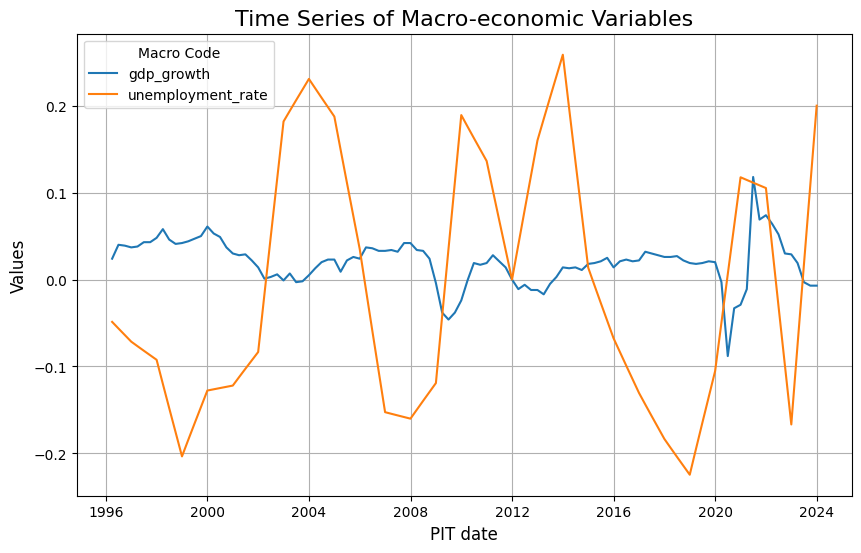

In [7]:
import matplotlib.pyplot as plt

# Step 2: Plot each time series
plt.figure(figsize=(10, 6))

for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], label=column)

# Add labels, title, and legend
plt.title("Time Series of Macro-economic Variables", fontsize=16)
plt.xlabel("PIT date", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.legend(title="Macro Code")
plt.grid(True)

# Show the plot
plt.show()

# VECM

In [8]:
def plot_vecm_data(vecm_data, title="VECM Data Visualization"):
    """
    Plots each column in vecm_data as a time series.
    
    Parameters:
        vecm_data (pd.DataFrame): DataFrame where each column is a time series.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 6))  # Set the figure size
    
    # Plot each time series
    for column in vecm_data.columns:
        plt.plot(vecm_data.index, vecm_data[column], label=column)
    
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(loc="best", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
def remove_outliers(data, method="iqr", threshold=1.5):
    """
    Removes outliers from a DataFrame based on the specified method.
    
    Parameters:
        data (pd.DataFrame): Input DataFrame with numeric values.
        method (str): The method to detect outliers. Options are:
                      "iqr" (Interquartile Range) or "zscore" (Z-score).
        threshold (float): Threshold for detecting outliers:
                           - For "iqr", the multiplier for IQR (default=1.5).
                           - For "zscore", the maximum Z-score value (default=3.0).
    
    Returns:
        pd.DataFrame: DataFrame with outliers removed.
    """
    if method not in ["iqr", "zscore"]:
        raise ValueError("Invalid method. Choose 'iqr' or 'zscore'.")
    
    filtered_data = data.copy()
    
    if method == "iqr":
        # Apply IQR method
        for col in filtered_data.columns:
            Q1 = filtered_data[col].quantile(0.25)  # 25th percentile
            Q3 = filtered_data[col].quantile(0.75)  # 75th percentile
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            # Mask outliers and replace with NaN
            filtered_data[col] = np.where(
                (filtered_data[col] < lower_bound) | (filtered_data[col] > upper_bound),
                np.nan, filtered_data[col]
            )
            
    elif method == "zscore":
        # Apply Z-score method
        for col in filtered_data.columns:
            mean = filtered_data[col].mean()
            std = filtered_data[col].std()
            
            # Calculate Z-scores
            z_scores = (filtered_data[col] - mean) / std
            filtered_data[col] = np.where(
                np.abs(z_scores) > threshold, np.nan, filtered_data[col]
            )
    
    # Optionally, drop rows with NaN values after filtering
    filtered_data.dropna(inplace=True)
    
    return filtered_data

In [10]:
from statsmodels.tsa.vector_ar.vecm import VECM

# Step 1: Reshape data into a pivot table
pivot_df = df.pivot(index='pit_date', columns='macro_code', values='transformed_time_series_value')
pivot_df.index = pd.to_datetime(pivot_df.index)  # Ensure datetime index

# # Step 2: Reshape data into a pivot table
# pivot_df = df.pivot(index='pit_date', columns='macro_code', values='time_series_value')
# pivot_df.index = pd.to_datetime(pivot_df.index)  # Ensure datetime index

# Step 3: Interpolate
pivot_df = pivot_df.asfreq('QE').interpolate(method='cubic')  # Cubic interpolation
pivot_df = pivot_df.dropna()


# Step 4: Set vecm data
vecm_data = pivot_df

# Step 5: Ensuring index is datetime type
vecm_data.index = pd.to_datetime(vecm_data.index)

# Step 6: Set the frequency to quarterly
vecm_data = vecm_data.asfreq('QE')

# Step 7: Interpolate
vecm_data = vecm_data.asfreq('QE').interpolate(method='linear')  # Cubic interpolation

# # Remove outliers
# vecm_data = remove_outliers(vecm_data, method="iqr", threshold=1.5)

# Fit the VECM
vecm_model = VECM(vecm_data, k_ar_diff=12, coint_rank=1, deterministic='ci')
vecm_fit = vecm_model.fit()

# Summary of the model
print(vecm_data)
print(vecm_fit.summary())
print(vecm_data.count())

macro_code  gdp_growth  unemployment_rate
pit_date                                 
1996-03-31       0.024          -0.060937
1996-06-30       0.040          -0.070677
1996-09-30       0.039          -0.073224
1996-12-31       0.037          -0.071429
1997-03-31       0.038          -0.068536
...                ...                ...
2022-09-30       0.030          -0.114300
2022-12-31       0.029          -0.166667
2023-03-31       0.019          -0.178763
2023-06-30      -0.003          -0.134399
2023-09-30      -0.007          -0.014071

[111 rows x 2 columns]
Det. terms outside the coint. relation & lagged endog. parameters for equation gdp_growth
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
L1.gdp_growth            -0.3387      0.102     -3.316      0.001      -0.539      -0.138
L1.unemployment_rate     -2.1632      0.566     -3.823      0.000     

# SARIMAX

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.85383D+00    |proj g|=  3.01731D+01

At iterate    5    f= -2.25172D+00    |proj g|=  8.05442D+00

At iterate   10    f= -2.33887D+00    |proj g|=  1.44719D+00

At iterate   15    f= -2.34503D+00    |proj g|=  4.71200D+00

At iterate   20    f= -2.35853D+00    |proj g|=  2.36954D-01

At iterate   25    f= -2.36541D+00    |proj g|=  1.48223D+01

At iterate   30    f= -2.40481D+00    |proj g|=  3.63620D-01

At iterate   35    f= -2.41833D+00    |proj g|=  1.96732D+00

At iterate   40    f= -2.42494D+00    |proj g|=  4.78835D+00

At iterate   45    f= -2.48148D+00    |proj g|=  6.29097D+01

At iterate   50    f= -2.50608D+00    |proj g|=  3.54003D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
/Users/nielsvanwinden/Projects/Projects/Inholland/Scenario_Generator/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


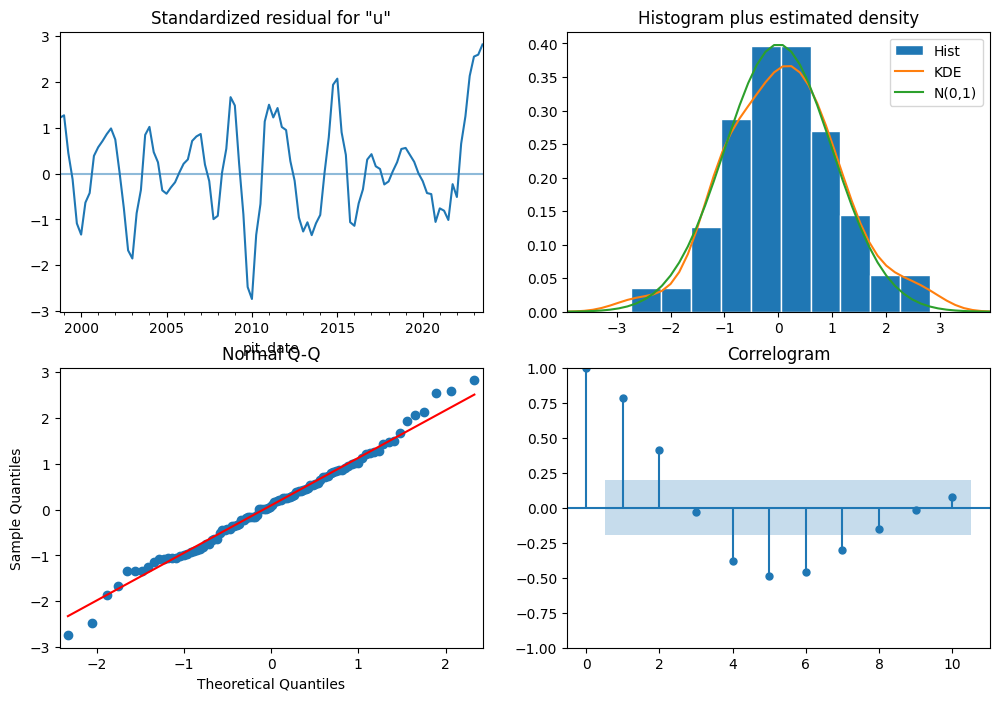

In [11]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt


# Drop rows with NaN values created by lagging
pivot_df = pivot_df.dropna()

# Define the dependent and exogenous variables
y = pivot_df['unemployment_rate']
exog = pivot_df[['gdp_growth']]

# Refine SARIMAX with simpler seasonal order
sarimax_model_refined = SARIMAX(
    pivot_df['unemployment_rate'],
    exog=pivot_df[['gdp_growth']],
    order=(1, 1, 1),            # Non-seasonal ARIMA terms
    seasonal_order=(0, 1, 1, 4), # Simpler seasonal terms
    enforce_stationarity=False,
    enforce_invertibility=False,
)

# Fit the refined model
refined_fit = sarimax_model_refined.fit()

# Print summary and diagnostics
print(refined_fit.summary())
refined_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [12]:
# Make predictions
forecast = sarimax_results.get_prediction(start=pivot_df.index[0], end=pivot_df.index[-1], exog=exog)
forecast_ci = forecast.conf_int()

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(pivot_df.index, y, label="Actual Unemployment Rate", color="blue")
plt.plot(pivot_df.index, forecast.predicted_mean, label="Predicted Unemployment Rate", color="orange")
plt.fill_between(
    pivot_df.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="orange",
    alpha=0.2,
    label="Confidence Interval",
)
plt.legend()
plt.title("SARIMAX Model: Unemployment Rate Prediction")
plt.xlabel("Time")
plt.ylabel("Unemployment Rate")
plt.grid()
plt.show()

NameError: name 'sarimax_results' is not defined

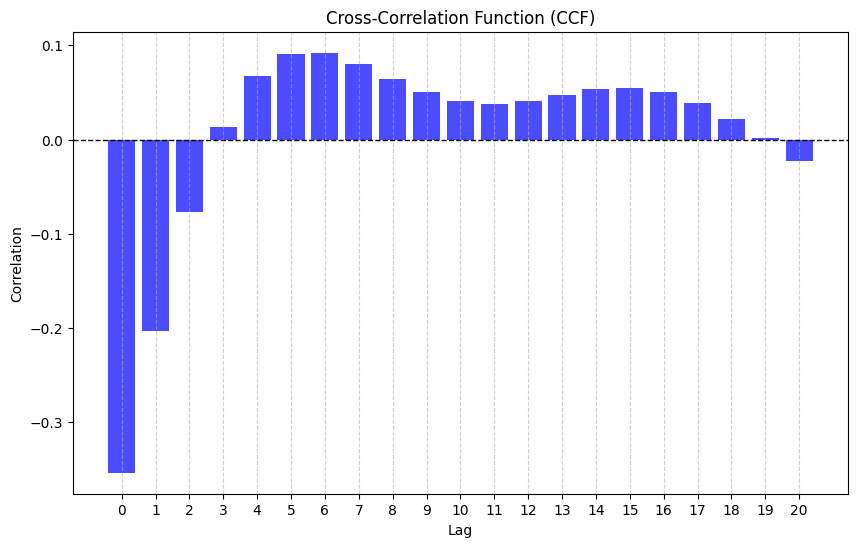

In [13]:
from statsmodels.tsa.stattools import ccf
import numpy as np
import matplotlib.pyplot as plt

# Specify maximum number of lags
max_lags = 20

# Calculate cross-correlation for 'gdp_growth' and 'unemployment_rate'
corr_values = ccf(pivot_df['gdp_growth'], pivot_df['unemployment_rate'], adjusted=False)[:max_lags + 1]  # Truncate to max_lags

# Generate the corresponding lags
lags = np.arange(0, len(corr_values))

# Plot the Cross-Correlation
plt.figure(figsize=(10, 6))
plt.bar(lags, corr_values, width=0.8, color='blue', alpha=0.7)
plt.axhline(0, color='black', linewidth=1.0, linestyle='--')
plt.title("Cross-Correlation Function (CCF)")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.xticks(lags)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()